# Kelvin Helmholtz instability with Dye module
In this notebook, we will show how to work out a "2D" classical HD simulation using MHDFlows. The Dye module also deployed to illustrate the flow.  
Be careful that the Dye module itself serve as a passive scalar here and the result may not be physical due to the implemention we are using in this version. ($\rho < 0 $  for some pixel)   
For the video illustration, netvigate to this [youtube link](https://www.youtube.com/watch?v=04psrwxXwbg).

In [1]:
using MHDFlows,PyPlot,CUDA
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/2BZya/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
#parameters
Nx =  1500;
Ny =  1500;
Nz =  4;#div(N,32);
Lx = 2π;
Ly = 2π;
Lz = 2π;

Re = 50000;
U  = 0.1;
ν  = U*Lx/Re
η = ν; # Pr = 1;
nothingfunction(args...) = nothing;
GPUprob =          Problem(GPU();
             # Numerical parameters
                           nx = Nx,
                           ny = Ny,
                           nz = Nz,
                           Lx = Lx,
                           Ly = Ly,
                           Lz = Lz,
              # Drag and/or hyper-viscosity for velocity/B-field
                            ν = ν,
                           nν = 0,
                            η = η,
                           nη = 0,
              # Declare if turn on magnetic field, VP method, Dye module
                      B_field = false,
              	    VP_method = false,
                   Dye_Module = true,
             # Timestepper and equation options
                      stepper = "RK4",
                        calcF = nothingfunction,
             # Float type and dealiasing
                            T = Float32,
             aliased_fraction = 1/3,
             # User defined params/vars
                     usr_vars = [],
                   usr_params = [],
                     usr_func = [])           

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: ON, at prob.dye
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [4]:
#Kelvin Helmholtz instability
function ProblemKH!(prob; T=Float32)
  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  ux,uy,uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  bx,by,bz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  U₀x,U₀y,U₀z = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);  
  ρ = zeros(T,nx,ny,nz);
  ρₖ = copy(prob.vars.uxh);  
  for k ∈ 1:nz,j ∈ 1:ny,i ∈ 1:nx  
    U₀x[i,j,k] = 0;   
    U₀y[i,j,k] = 0;  
    if (ny/2)+250 >= j >= (ny/2)-250 
        U₀x[i,j,k] += 0.1;
        U₀y[i,j,k] += 1e-5*sin(x[i]);
        ρ[i,j,k] = 1;
    end   
  end
  ux,uy,uz = U₀x,U₀y,U₀z;
    
  copyto!(prob.vars.ux, deepcopy(ux));
  copyto!(prob.vars.uy, deepcopy(uy));
  copyto!(prob.vars.uz, deepcopy(uz));
  copyto!(prob.dye.ρ, ρ);


  #Update V + B Fourier Conponment
  uxh = @view prob.sol[:, :, :, prob.params.ux_ind];
  uyh = @view prob.sol[:, :, :, prob.params.uy_ind];
  uzh = @view prob.sol[:, :, :, prob.params.uz_ind];
  ρh  = prob.dye.tmp.sol₀;

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(ρh, prob.grid.rfftplan, prob.dye.ρ);
    
  copyto!(prob.vars.uxh, deepcopy(uxh));
  copyto!(prob.vars.uyh, deepcopy(uyh));
  copyto!(prob.vars.uzh, deepcopy(uzh));
end

ProblemKH! (generic function with 1 method)

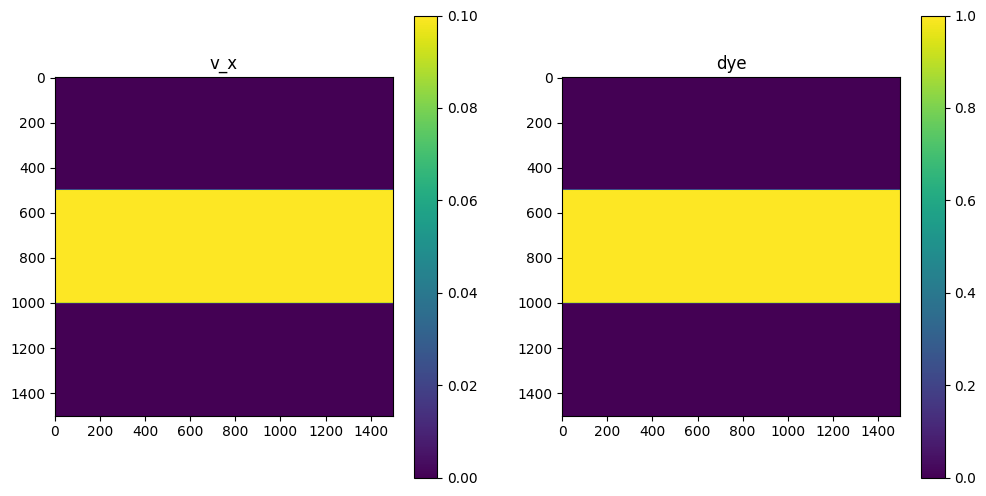

PyObject <matplotlib.colorbar.Colorbar object at 0x7f208030e518>

In [5]:
#Setting up and Plotting the IC
ProblemKH!(GPUprob;T=Float32);

figure(figsize=(12,6))
subplot(121);title("v_x")
imshow(Array(GPUprob.vars.ux[:,:,1])');colorbar()
subplot(122);title("dye")
ρ = GPUprob.dye.ρ;
imshow(Array(ρ[:,:,1])');colorbar()

In [6]:
#Actual Computation
TimeIntegrator!(GPUprob, 100, 8000;loop_number = 500)

n =      500, t =     5.21, KE =   0.0022
n =     1000, t =     10.4, KE =  0.00219
n =     1500, t =     15.7, KE =  0.00219
n =     2000, t =     20.9, KE =  0.00218
n =     2500, t =     26.2, KE =  0.00218
n =     3000, t =     31.4, KE =  0.00218
n =     3500, t =     36.6, KE =  0.00217
n =     4000, t =     41.8, KE =  0.00217
n =     4500, t =     47.0, KE =  0.00217
n =     5000, t =     52.1, KE =  0.00217
n =     5500, t =     57.0, KE =  0.00216
n =     6000, t =     61.6, KE =  0.00216
n =     6500, t =     66.2, KE =  0.00216
n =     7000, t =     70.8, KE =  0.00216
n =     7500, t =     75.2, KE =  0.00216
n =     8000, t =     79.6, KE =  0.00216


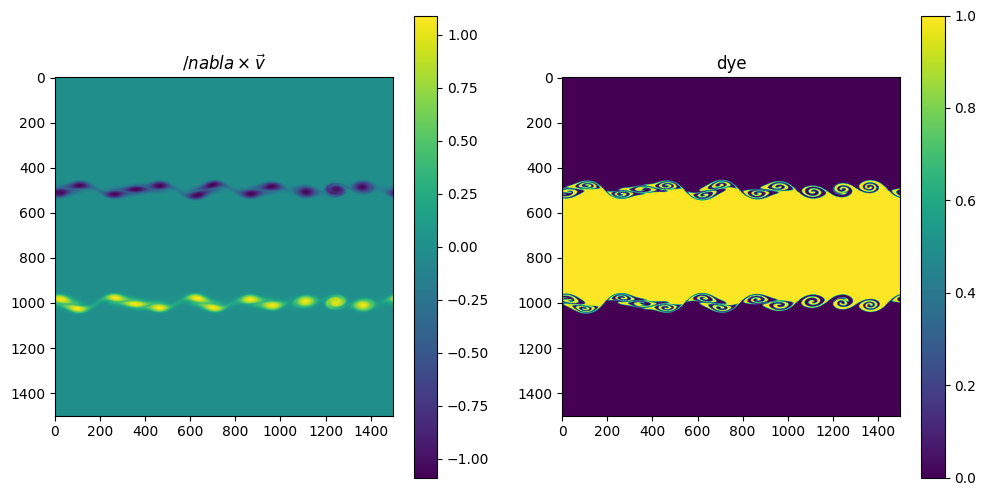

PyObject <matplotlib.colorbar.Colorbar object at 0x7f203c084f98>

In [12]:
iv,jv,kv = Array(GPUprob.vars.ux),Array(GPUprob.vars.uy),Array(GPUprob.vars.uz)
cvx,cvy,cvz = Curl(iv,jv,kv);
figure(figsize=(12,6))
subplot(121);title(L"/nabla \times \vec{v}")
imshow(cvz[:,:,1]');colorbar()
subplot(122);title("dye")
ρ = GPUprob.dye.ρ;
imshow(Array(ρ[:,:,1])',vmin=0,vmax=1);colorbar()